# Simulation and Inference for Neuroscience
## Final Project: Parameter inference for the pyloric network

The notebook below contains the final project.
The final project is meant to be a bit more open-endend and less structured than the exercises. You are free to answer the questions below as you see fit and you can re-use as much of your previous code as you want. You will work be graded in groups of 2, but you are welcome to collaborate with others. 

If you need additional dependencies to solve any of the questions, feel free to install and/or import them. Make sure you document your process and thinking, such that it is clear how you arrived at your final answer.

The project will be graded based on a brief presentation and a follow-up interview about your code and results (10-15min). Take note of the following:
- Make sure you understand what you are doing and you can explain / defend your analysis.
- Ensure you're notebook is presentable and easy to follow. Intermediate results should be backed up by plots (and / or printouts). Plots should be readable
- You should be able to present what you did with the help of your plots in about 2-5 minutes.
- Make sure the notebook can be run from start to finish without errors (if you cache intermediate results, it is fine to load them).
- We encourage the use of coding assistants.


**Before you start, please add your name below!**

**Names:** _Firstname Lastname, Firstname Lastname_

---

In the following project you will perform parameter inference on the pyloric network of the stomatogastric ganglion (STG) of crustaceans.

The pyloric network of the stomatogastric ganglion (STG) is a well-studied component of the crustacean nervous system that provides valuable insights into neural circuit function. Computational models of the pyloric network have been instrumental in understanding how neural circuits maintain functional stability despite biological variability and perturbations. It consists of about 14 neurons that generate a rhythmic motor pattern controlling the pylorus of the crustacean stomach that are connected by a set of Cholinergic and Glutamatergic synapses.

The key neuron types include:
- Anterior Burster (AB) neuron
- Pyloric Dilator (PD) neurons
- Lateral Pyloric (LP) neuron
- Pyloric (PY) neurons

The simplified model that we will be using in the following approximates all neurons of the same type with a single compartmental model and also treats the electrically coupled AB and PD neurons as a single neuron. This leads to the following circuit:

![pyloric network](../assets/pyloric_schematic.png)

For more context you can read the following papers:
- [Similar network activity from disparate circuit parameters](../assets/nn1352.pdf)
- [Alternative to hand-tuning conductance-based models](../assets/alternative-to-hand-tuning-conductance-based-models-tqk0oa7i15.pdf)
- [Training deep neural density estimators to identify mechanistic models of neural dynamics](../assets/elife-56261-v3-4.pdf)

In this project, we will focus on inferring parameters of the synapses.


In [1]:
# configure jax to use 64bit precision and cpu
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [2]:
import sys
sys.path.append("..")

from pyloric import PyloricNetwork
import jaxley as jx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
import numpy as np
import jax

import torch
from torch import Tensor
from numpy import ndarray
from typing import Union, Optional, Tuple

# sbi imports
from sbi.utils import BoxUniform
from sbi.inference import SNPE
from sbi.analysis import pairplot



In [3]:
# utils
def plot_pyloric(ts: Union[ndarray, Tensor], v: Union[ndarray, Tensor], axs: Optional[plt.Axes] = None, **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the voltage of the pyloric network for each neuron.

    Args:
        ts: The time points to plot.
        v: The voltage of the pyloric network.
        axs: The axes to plot on. Allows to plot multiple traces in one figure.

    Returns:
        fig: The figure.
        axs: The axes.
    """
    if axs is None:
        fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True, layout='constrained')
    for ax_i, v_i in zip(axs, v):
        ax_i.plot(ts, v_i, **kwargs)
        ax_i.set_ylabel('V (mV)')
    axs[0].set_title(f'AB/PD')
    axs[1].set_title(f'LP')
    axs[2].set_title(f'PY')
    axs[2].set_xlabel('t (ms)')
    return fig, axs

In [ ]:
def compare_plot(
    ts_obs: Union[np.ndarray, torch.Tensor], 
    v_obs: Union[np.ndarray, torch.Tensor], 
    ts_sim: Union[np.ndarray, torch.Tensor], 
    v_sim: Union[np.ndarray, torch.Tensor], 
    axs: Optional[plt.Axes] = None, 
    **kwargs
) -> Tuple[plt.Figure, plt.Axes]:
    """Compare observed vs. simulated voltage traces for the pyloric network.

    Args:
        ts_obs: Time points for observed data.
        v_obs: Voltage traces from observed data.
        ts_sim: Time points for simulated data.
        v_sim: Voltage traces from simulated data.
        axs: Optional, existing axes to plot on.

    Returns:
        fig: The figure.
        axs: The axes.
    """
    if axs is None:
        fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True, layout='constrained')

    # Ensure data is converted to NumPy for compatibility
    if isinstance(v_obs, torch.Tensor): v_obs = v_obs.cpu().numpy()
    if isinstance(v_sim, torch.Tensor): v_sim = v_sim.cpu().numpy()
    if isinstance(ts_obs, torch.Tensor): ts_obs = ts_obs.cpu().numpy()
    if isinstance(ts_sim, torch.Tensor): ts_sim = ts_sim.cpu().numpy()

    # Plot observed and simulated data on the same axes
    for ax, v_obs_i, v_sim_i in zip(axs, v_obs, v_sim):
        ax.plot(ts_obs, v_obs_i, label="Observed", color="blue", **kwargs)
        ax.plot(ts_sim, v_sim_i, label="Simulated", color="red", linestyle="dashed", **kwargs)
        ax.set_ylabel('V (mV)')
        ax.legend()

    axs[0].set_title(f'AB/PD')
    axs[1].set_title(f'LP')
    axs[2].set_title(f'PY')
    axs[2].set_xlabel('t (ms)')

    return fig, axs

In [4]:
net = PyloricNetwork() # instantiate the pyloric circuit model
net.record() # record the voltage of all neurons
net.init_states() # initialize the states

# set up the simulation parameters (no stimulus needed)
# Full Length
dt = 0.025
t_max = 4_000
ts = jnp.arange(0, t_max, dt)

# short 
DT = 0.025
T_MAX_SHORT = 1_500 
TS_SHORT = jnp.arange(0, T_MAX_SHORT, dt)

@jit # compile the simulator
def simulate(params: jnp.ndarray) -> jnp.ndarray:
    """Simulate the pyloric network.
    
    Args:
        params: The synaptic conductances of shape (7,).
        params[[0, 2, 4, 5, 6]]: Glutamatergic synapses.
        params[[1, 3]]: Cholinergic synapses.
        for details see `PyloricNetwork`.

    Returns:
        v: The voltages of the pyloric network. Shape (3, num_steps).
    """
    # set the synapse parameters
    pstate = None
    for i in [0,2,4,5,6]:
        pstate = net.select(edges=i).data_set("GlutamatergicSynapse_gS", params[i], pstate)
    for i in [1,3]:
        pstate = net.select(edges=i).data_set("CholinergicSynapse_gS", params[i], pstate)
    
    # simulate the network
    v = jx.integrate(net, param_state=pstate, t_max=T_MAX_SHORT-DT)
    return v


Added 3 recordings. See `.recordings` for details.


### Inspect the model
Familiarize yourself with the model. Read the code in `pyloric/channels.py`, `pyloric/synapses.py` and `pyloric/model.py` to gain a rough understanding of how it is implemented. You should pay particular attention to `PyloricNetwork`.

In addition you can use `.nodes` and `.edges` to inspect the neurons and synapses respectively.

Also take a closer look at the imported data and try to understand what you are looking at.

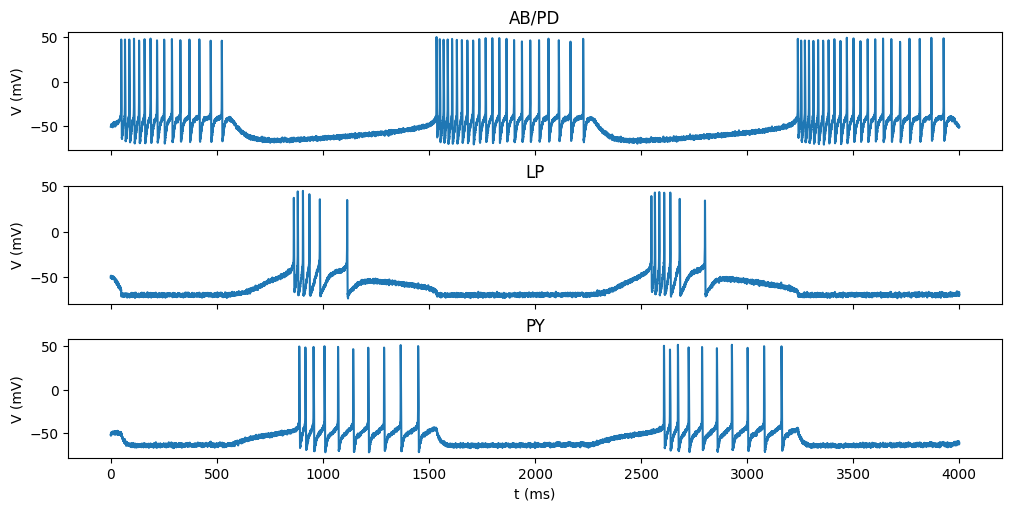

In [8]:
# import and plot the data
t_obs, *v_obs = jnp.array(np.loadtxt("../data/pyloric_observation.csv", unpack=True))
v_obs = jnp.array(v_obs)
fig, axs = plot_pyloric(t_obs, v_obs)
plt.show()

### Identify suitable synpaptic conductances for the pyloric network
In the following task we will try to identify parameters for the pyloric network that reproduce the observed activity from our experimental data. You are free in your choice of method and how you approach this task.

**Be careful**, the observation is very long (4s), this makes the simuluator quite expensive to run for many simulations. While developing your code, think about how you can get a way with running it less often or more cheaply. I.e. fit only 1 second (or even less) of the observation and see if it generalizes to the whole observation. Also once you are sure you're pipeline is working, make sure to cache intermediate results to avoid re-running the simulator.


Make sure the results you obtain are sound. It is sufficient to do this qualitatively, but bonus points if you can do it quantitatively.

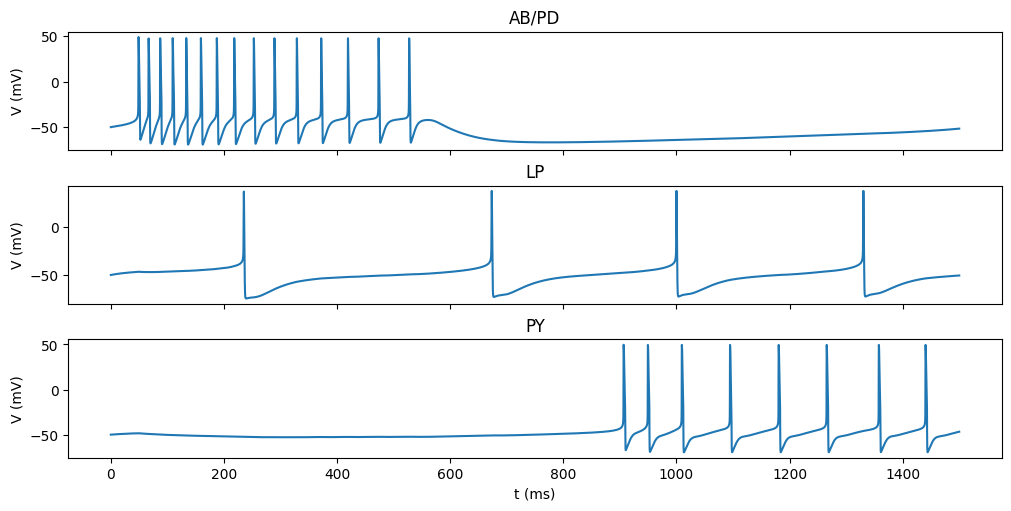

In [9]:
# Here is an example of how to run the simulator
param_guess = 0.001*jnp.ones(7)
v = simulate(param_guess)
fig, axs = plot_pyloric(TS_SHORT, v)
plt.show()

In [10]:
# ...and how to parallelize the simulation
parallel_simulate = vmap(simulate)
key = jax.random.PRNGKey(0)

param_batch = param_guess.reshape(1,-1).repeat(5,axis=0) + 0.0001*jax.random.normal(key, (5,7))
v_samples = parallel_simulate(param_batch)

# ... and how to adapt the simulator to the sbi framework
def simulate_for_sbi(theta: Tensor) -> Tensor:
    """Simulate the pyloric network for the given parameters.
    
    Args:
        theta: The parameters of the synapses. Shape (n_samples,7).
        
    Returns:
        v: The voltages of the pyloric network. Shape (n_samples, 3, num_steps).
    """
    theta = theta.to(torch.float64).numpy()
    v = torch.tensor(parallel_simulate(theta)).to(torch.float32)
    noise = torch.randn_like(v) * 0.1 # add a bit of observation noise
    v += noise
    return v

In [11]:
# implement your pipeline here
bounds = (1e-5, 10) # uS


# our own code 

### Hand-Tuningg Parameters

In [15]:
print(v_obs.shape)

(3, 16000)


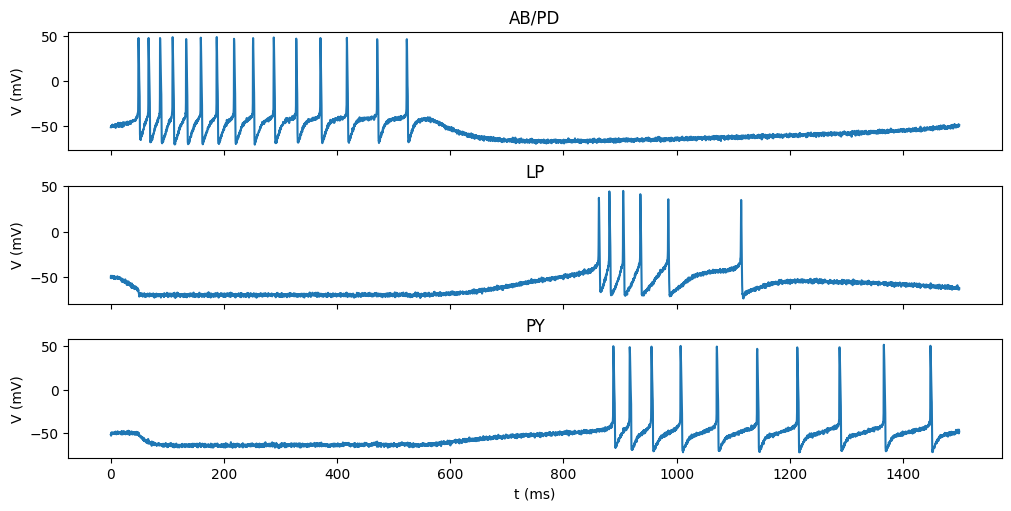

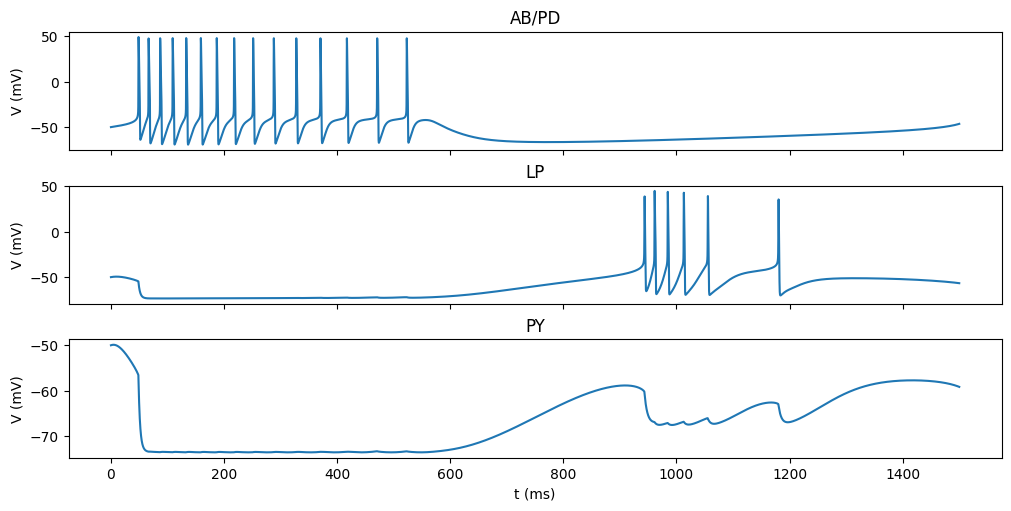

In [12]:
# hand-tune the parameters
param_guess = jnp.array([0.1, 0.1, 0.1, 0.1, 0.0, 0.1, 0.1])
v_guess = simulate(param_guess) 
# def plot_pyloric(ts: Union[ndarray, Tensor], v: Union[ndarray, Tensor], axs: Optional[plt.Axes] = None, **kwargs) -> Tuple[plt.Figure, plt.Axes]:

plot_pyloric(t_obs[:6000], v_obs[:, :6000])
plot_pyloric(TS_SHORT, v_guess)


plt.show()

### SNPE

In [20]:
# define Uniform prior for the parameters
prior_min = torch.tensor([bounds[0]]*7)
prior_max = torch.tensor([bounds[1]]*7)

prior = BoxUniform(low=prior_min, high=prior_max)

In [11]:
# ... and how to adapt the simulator to the sbi framework
def simulate_for_sbi(theta: Tensor) -> Tensor:
    """Simulate the pyloric network for the given parameters.
    
    Args:
        theta: The parameters of the synapses. Shape (n_samples,7).
        
    Returns:
        v: The voltages of the pyloric network. Shape (n_samples, 3, num_steps).
    """
    theta = theta.to(torch.float64).numpy()
    v = torch.tensor(parallel_simulate(theta)).to(torch.float32)
    noise = torch.randn_like(v) * 0.1 # add a bit of observation noise
    v += noise
    return v

def compute_summary_stats_torch(x: torch.tensor) -> torch.tensor:
    ft1 = torch.max(x, dim=-1).values
    ft2 = torch.min(x, dim=-1).values
    ft3 = torch.mean(x, dim=-1)
    ft4 = torch.std(x, dim=-1)
    stats = torch.stack([ft1, ft2, ft3, ft4], dim=-1)
    return stats


In [12]:
# v_train.flatten(start_dim=1).shape, v_obs.shape, torch.tensor(v_obs).flatten()[None].shape, type(v_train)

In [ ]:
num_samples = 1000
# draw samples from the prior, simulate and compute summary statistics
theta_train = prior.sample((num_samples,))
v_train = simulate_for_sbi(theta_train)
x_train = compute_summary_stats_torch(v_train.flatten(start_dim=1))
x_obs = compute_summary_stats_torch(torch.tensor(v_obs).flatten()[None])

# run NPE (one round of SNPE)
snpe = SNPE(prior, density_estimator="mdn")
infer = snpe.append_simulations(theta_train, x_train)
estimator = infer.train()
posterior = infer.build_posterior(sample_with='mcmc')

### Trial 1

In [14]:
"""
posterior.set_default_x(x_obs.flatten())

samples = posterior.sample((10, ))
print("Done")
top_indices = torch.argsort(posterior.log_prob(samples, x=x_obs))[:10]
v_top = simulate_for_sbi(samples[top_indices])

theta_map = posterior.map()
print(theta_map)
"""
x_obs = compute_summary_stats_torch(torch.tensor(v_obs).flatten()[None])

num_rounds = 2
num_simulations_per_round = 1000

snpe = SNPE(prior, density_estimator="mdn")

proposal = prior  # initial prior clearly defined

for round in range(num_rounds):
    # sample clearly from current proposal
    theta = proposal.sample((num_simulations_per_round,))
    
    # simulate clearly and compute summary stats
    v = simulate_for_sbi(theta)
    x = compute_summary_stats_torch(v.flatten(start_dim=1))
    
    _ = snpe.append_simulations(theta, x, proposal=proposal).train()
    posterior = snpe.build_posterior(sample_with='mcmc').set_default_x(x_obs)

    proposal = posterior


 Neural network successfully converged after 92 epochs.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 121 epochs.

In [15]:
import pickle
with open('posterior.pkl', 'wb') as f:
    pickle.dump(posterior, f)

In [16]:
# final posterior ready after multiple rounds
theta_map = posterior.map()
print(f"MAP: {theta_map}")

MAP: tensor([[7.9255e-02, 1.2101e-01, 9.9525e+00, 1.5291e-01, 1.7475e-03, 4.5700e+00,
         1.5179e-01]])


(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: title={'center': 'AB/PD'}, ylabel='V (mV)'>,
        <Axes: title={'center': 'LP'}, ylabel='V (mV)'>,
        <Axes: title={'center': 'PY'}, xlabel='t (ms)', ylabel='V (mV)'>],
       dtype=object))

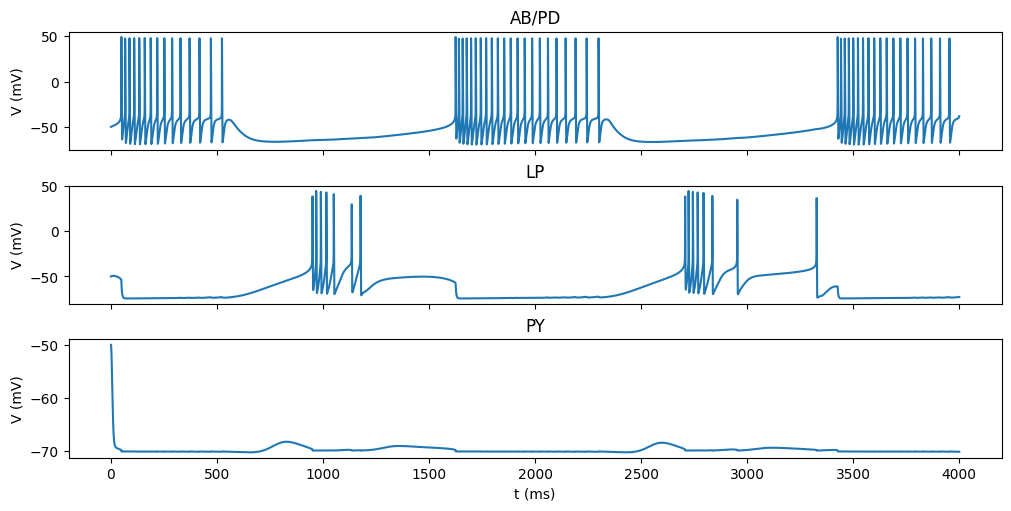

In [ ]:
v_guess = simulate(jnp.array([7.9255e-02, 1.2101e-01, 9.9525e+00, 1.5291e-01, 1.7475e-03, 4.5700e+00,
         1.5179e-01]))
# def plot_pyloric(ts: Union[ndarray, Tensor], v: Union[ndarray, Tensor], axs: Optional[plt.Axes] = None, **kwargs) -> Tuple[plt.Figure, plt.Axes]:
plot_pyloric(ts, v_guess)

In [1]:
pairplot(samples, labels=bounds*7, points=theta_map)
plt.show()

NameError: name 'pairplot' is not defined

In [ ]:
#v_guess = simulate(param_guess)
# def plot_pyloric(ts: Union[ndarray, Tensor], v: Union[ndarray, Tensor], axs: Optional[plt.Axes] = None, **kwargs) -> Tuple[plt.Figure, plt.Axes]:

plot_pyloric(t_obs, v_obs)
plot_pyloric(ts, v_top)


### Trial 2

In [28]:
def simulate_for_sbi(theta: Tensor) -> Tensor:
    """Simulate the pyloric network for the given parameters.
    
    Args:
        theta: The parameters of the synapses. Shape (n_samples,7).
        
    Returns:
        v: The voltages of the pyloric network. Shape (n_samples, 3, num_steps).
    """
    theta = theta.to(torch.float64).numpy()
    v = torch.tensor(parallel_simulate(theta)).to(torch.float32)
    noise = torch.randn_like(v) * 0.1 # add a bit of observation noise
    v += noise
    return v

def compute_summary_stats_torch(x: torch.tensor) -> torch.tensor:
    ft1 = torch.max(x, dim=-1).values
    ft2 = torch.min(x, dim=-1).values
    ft3 = torch.mean(x, dim=-1)
    ft4 = torch.std(x, dim=-1)
    stats = torch.stack([ft1, ft2, ft3, ft4], dim=-1)
    return stats


In [ ]:
from scipy.signal import find_peaks

def count_peaks(voltage_trace, height=30):
    voltage_np = voltage_trace.cpu().numpy()
    peaks, _ = find_peaks(voltage_np, height=height)
    return len(peaks)

# Using this clearly inside your summary stats:
def compute_summary_stats_torch(x: torch.tensor) -> torch.tensor:
    batch_size, neurons, timesteps = x.shape
    peak_counts = torch.zeros((batch_size, neurons))

    for i in range(batch_size):
        for j in range(neurons):
            peak_counts[i, j] = count_peaks(x[i, j, :])

    ft1 = torch.max(x, dim=-1).values
    ft2 = torch.min(x, dim=-1).values
    ft3 = torch.mean(x, dim=-1)
    ft4 = torch.std(x, dim=-1)

    stats = torch.stack([ft1, ft2, ft3, ft4, peak_counts], dim=-1)
    return stats.flatten(start_dim=1)


In [ ]:
# define Uniform prior for the parameters
prior_min = torch.tensor([bounds[0]]*7)
prior_max = torch.tensor([bounds[1]]*7)

prior = BoxUniform(low=prior_min, high=prior_max)

# sample from prior
theta_train = prior.sample((num_samples,))
# simulate clearly and compute summary stats
v_train = simulate_for_sbi(theta_train)
x_train = compute_summary_stats_torch(v_train.flatten(start_dim=1))
x_obs = compute_summary_stats_torch(torch.tensor(v_obs[:,:6000]).flatten()[None])
# num samples to draw from prior
num_samples = 10_000

snpe = SNPE(prior, density_estimator="mdn")


# simulate clearly and compute summary stats
v_sim = simulate_for_sbi(theta)
x_sim = compute_summary_stats_torch(v.flatten(start_dim=1))

_ = snpe.append_simulations(theta, x_sim, proposal=prior).train()
posterior = snpe.build_posterior(sample_with='mcmc').set_default_x(x_obs)

: 

In [ ]:
with open('posterior_trial_2.pkl', 'wb') as f:
    pickle.dump(posterior, f)

In [19]:
# final posterior ready after multiple rounds
theta_map = posterior.map()
print(f"MAP: {theta_map}")

MAP: tensor([[0.6021, 0.0547, 0.0025, 0.0184, 0.0411, 0.0875, 2.3773]])


(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: title={'center': 'AB/PD'}, ylabel='V (mV)'>,
        <Axes: title={'center': 'LP'}, ylabel='V (mV)'>,
        <Axes: title={'center': 'PY'}, xlabel='t (ms)', ylabel='V (mV)'>],
       dtype=object))

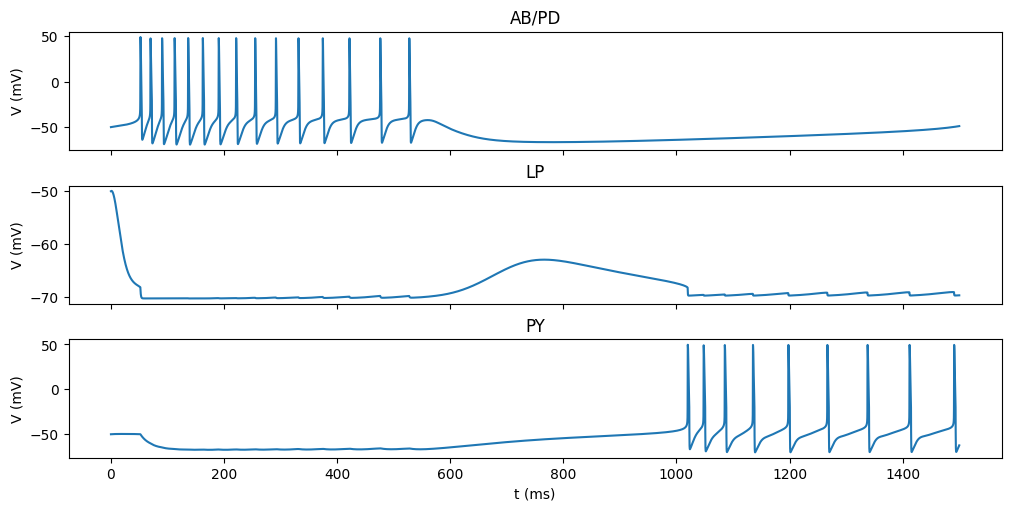

In [20]:
# [9.9730, 0.6827, 0.0509, 0.0391, 0.6381, 0.0279, 9.8579]
v_guess = simulate(jnp.array([0.6021, 0.0547, 0.0025, 0.0184, 0.0411, 0.0875, 2.3773]))
# def plot_pyloric(ts: Union[ndarray, Tensor], v: Union[ndarray, Tensor], axs: Optional[plt.Axes] = None, **kwargs) -> Tuple[plt.Figure, plt.Axes]:
plot_pyloric(TS_SHORT, v_guess)